In [1]:
# Check Python and library versions (install once if missing)
# !pip install tensorflow pandas scikit-learn matplotlib

import sys, os
import tensorflow as tf
import pandas as pd

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("Pandas:", pd.__version__)


Python: 3.9.25 (main, Nov  3 2025, 22:29:32) 
[Clang 20.1.8 ]
TensorFlow: 2.20.0
Pandas: 2.3.3


In [2]:
# Load essential packages for data handling, model building, and evaluation
import os, random, re, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers


In [3]:
# Define paths and make output folders
PROJECT_ROOT = "/Users/anudeep/Documents/glaucoma_detection"
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "clinical_notes.csv")
OUT_DIR = os.path.join(PROJECT_ROOT, "models")
os.makedirs(OUT_DIR, exist_ok=True)

# Fix random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("DATA_PATH:", DATA_PATH)
print("OUT_DIR:", OUT_DIR)


DATA_PATH: /Users/anudeep/Documents/glaucoma_detection/data/clinical_notes.csv
OUT_DIR: /Users/anudeep/Documents/glaucoma_detection/models


In [4]:
# Load the CSV and show first few rows
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(3)


Shape: (10000, 10)
Columns: ['age', 'gender', 'race', 'ethnicity', 'language', 'maritalstatus', 'note', 'gpt4_summary', 'glaucoma', 'use']


,age,gender,race,ethnicity,language,maritalstatus,note,gpt4_summary,glaucoma,use
0,56.56,female,black,non-hispanic,english,single,ms. PERSON is a 56 yo woman presenting to esta...,The 56 y/o female patient has optic nerve head...,yes,training
1,53.91,female,white,non-hispanic,english,single,referred for evaluation of narrow angles ou #p...,Patient was referred for narrow angle evaluati...,yes,training
2,46.30,female,white,non-hispanic,english,single,1. left upper lid ptosis: occurred after botox...,"Patient experienced ptosis, ear and eye pain, ...",no,training


In [5]:
print(df[df['glaucoma'] == 'no']['glaucoma'])

2       no
10      no
11      no
13      no
18      no
        ..
9991    no
9996    no
9997    no
9998    no
9999    no
Name: glaucoma, Length: 4952, dtype: object


In [6]:
df['glaucoma'] = df['glaucoma'].map({'yes':1, 'no':0})
df.head()

,age,gender,race,ethnicity,language,maritalstatus,note,gpt4_summary,glaucoma,use
0,56.56,female,black,non-hispanic,english,single,ms. PERSON is a 56 yo woman presenting to esta...,The 56 y/o female patient has optic nerve head...,1,training
1,53.91,female,white,non-hispanic,english,single,referred for evaluation of narrow angles ou #p...,Patient was referred for narrow angle evaluati...,1,training
2,46.30,female,white,non-hispanic,english,single,1. left upper lid ptosis: occurred after botox...,"Patient experienced ptosis, ear and eye pain, ...",0,training
3,66.52,male,white,non-hispanic,english,single,right plano +0.50 082 left LOCATION -0.50 83 a...,The patient has primary open angle glaucoma - ...,1,training
4,82.52,female,black,non-hispanic,english,divorced,in step. os with nonspecific peripheral defect...,The patient has nonspecific peripheral defects...,1,training


In [7]:
# Cell 6: Clean gpt4_summary in-place (no new column)
if 'gpt4_summary' not in df.columns:
    raise ValueError("Column 'gpt4_summary' not found in CSV.")

def clean_summary_inplace(s):
    s = '' if pd.isna(s) else str(s)
    s = s.strip().lower()
    s = re.sub(r'\s+', ' ', s)
    return s

df['gpt4_summary'] = df['gpt4_summary'].apply(clean_summary_inplace)

# show a sample
print("Sample cleaned summary (first row):")
print(df['gpt4_summary'].iloc[1][:400])


Sample cleaned summary (first row):
patient was referred for narrow angle evaluation, has cct 646/645 with a tmax of 17/16. patient has potential glaucoma, but no family history. possible optic nerve defects observed. no symptoms of angle closure. gonio shows narrow angles.


In [8]:
# Cell 7: Sanity check before split
print("Rows:", len(df))
print("glaucoma NaN count:", df['glaucoma'].isna().sum())
print("gpt4_summary empty count:", (df['gpt4_summary'].str.strip() == "").sum())

# If there are NaNs in glaucoma OR empty summaries, fix them before continuing.
if df['glaucoma'].isna().any() or (df['gpt4_summary'].str.strip() == "").any():
    print("\nALERT: Missing labels or empty summaries present. Please inspect and fix before splitting.")


Rows: 10000
glaucoma NaN count: 0
gpt4_summary empty count: 0


In [9]:
# Cell 8: Stratified split 70/15/15 (this will error if glaucoma has NaNs)
train_val, test = train_test_split(df, test_size=0.15, stratify=df['glaucoma'], random_state=SEED)
train, valid = train_test_split(train_val, test_size=0.1764706, stratify=train_val['glaucoma'], random_state=SEED)

# Reset indices for tidiness
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test  = test.reset_index(drop=True)

print("Train:", len(train), "Valid:", len(valid), "Test:", len(test))


Train: 6999 Valid: 1501 Test: 1500


In [10]:
# Cell 9: Tokenize & pad (train tokenizer on train set only)
MAX_VOCAB = 20000
MAX_LEN = 100
EMBED_DIM = 128

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train['gpt4_summary'])   # IMPORTANT: fit only on train

def seq_pad_from_series(series):
    seqs = tokenizer.texts_to_sequences(series)
    return pad_sequences(seqs, maxlen=MAX_LEN, padding='post', truncating='post')

X_train = seq_pad_from_series(train['gpt4_summary'])
X_valid = seq_pad_from_series(valid['gpt4_summary'])
X_test  = seq_pad_from_series(test['gpt4_summary'])

y_train = train['glaucoma'].values
y_valid = valid['glaucoma'].values
y_test  = test['glaucoma'].values

print("Vocab used:", min(MAX_VOCAB, len(tokenizer.word_index)+1))
print("X_train shape:", X_train.shape)


Vocab used: 7027
X_train shape: (6999, 100)


In [11]:
# Cell 10: Build simple 1D-CNN
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

def build_cnn(vocab_size=vocab_size, embed_dim=EMBED_DIM, max_len=MAX_LEN):
    inputs = layers.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, embed_dim, input_length=max_len)(inputs)
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    return model

model = build_cnn()
model.compile(optimizer=optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
model.summary()


/Users/anudeep/miniconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 128)       │       899,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 951,841 (3.63 MB)

 Trainable params: 951,841 (3.63 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Cell 11: Training
EPOCHS = 14
BATCH_SIZE = 32

es = callbacks.EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
ckpt = os.path.join(OUT_DIR, "best_cnn.h5")
mc = callbacks.ModelCheckpoint(ckpt, monitor='val_auc', mode='max', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, mc],
    verbose=1
)


Epoch 1/14
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6323 - loss: 0.6602

219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - auc: 0.6327 - loss: 0.6600 - val_auc: 0.8038 - val_loss: 0.5452
Epoch 2/14
213/219 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8285 - loss: 0.5103

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - auc: 0.8294 - loss: 0.5091 - val_auc: 0.8060 - val_loss: 0.5582
Epoch 3/14
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc: 0.9167 - loss: 0.3699 - val_auc: 0.7899 - val_loss: 0.6437
Epoch 4/14
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc: 0.9699 - loss: 0.2186 - val_auc: 0.7818 - val_loss: 0.8234
Epoch 5/14
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc: 0.9858 - loss: 0.1438 - val_auc: 0.7726 - val_loss: 0.9744


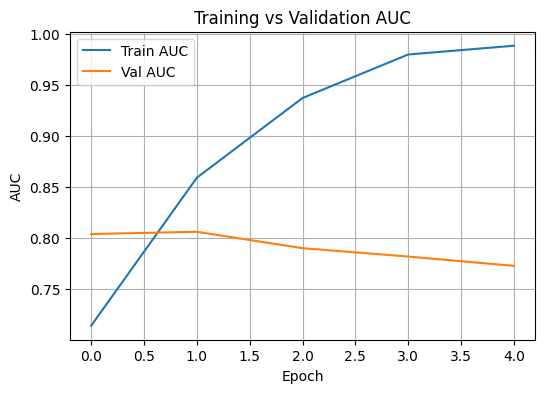

In [13]:
# Cell 12: Plot AUC curves
plt.figure(figsize=(6,4))
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.xlabel('Epoch'); plt.ylabel('AUC')
plt.title('Training vs Validation AUC'); plt.legend(); plt.grid(True)
plt.show()


In [14]:
# Cell 13: Evaluate on test
model.load_weights(ckpt)

y_prob = model.predict(X_test, batch_size=64).ravel()
auc_overall = roc_auc_score(y_test, y_prob)
print(f"Overall Test AUC: {auc_overall:.4f}")

thr = 0.5
y_pred = (y_prob >= thr).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn) if (tp + fn) else 0.0
specificity = tn / (tn + fp) if (tn + fp) else 0.0
print(f"Sensitivity @thr={thr}: {sensitivity:.4f}")
print(f"Specificity @thr={thr}: {specificity:.4f}")
print("Confusion matrix (tn, fp, fn, tp):", (tn, fp, fn, tp))


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Overall Test AUC: 0.8058
Sensitivity @thr=0.5: 0.8190
Specificity @thr=0.5: 0.6312
Confusion matrix (tn, fp, fn, tp): (np.int64(469), np.int64(274), np.int64(137), np.int64(620))


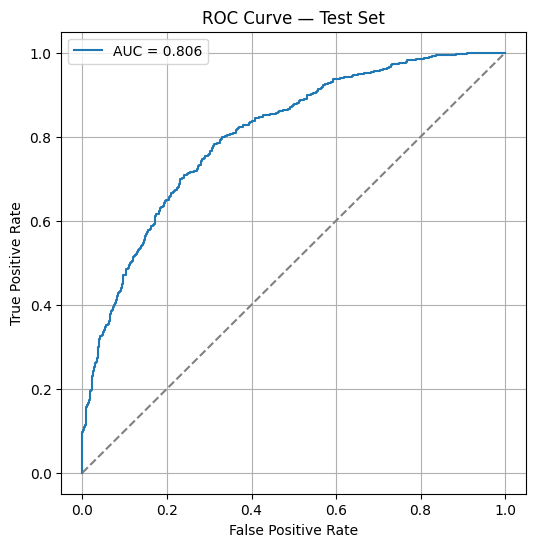

In [15]:
# Cell 14: ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_overall:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Test Set"); plt.legend(); plt.grid(True)
plt.show()


In [16]:
# Cell 15: Subgroup AUCs by race (if available)
if 'race' in test.columns:
    test_eval = test.copy()
    test_eval['pred_prob'] = y_prob
    print("Subgroup AUCs by race:")
    for r in test_eval['race'].unique():
        sub = test_eval[test_eval['race'] == r]
        if len(sub) < 10:
            print(f"{r:12s}: n={len(sub):3d} (too few to trust AUC)")
            continue
        auc_r = roc_auc_score(sub['glaucoma'], sub['pred_prob'])
        print(f"{r:12s}: n={len(sub):4d}  AUC={auc_r:.4f}")
else:
    print("No 'race' column in test set; subgroup eval skipped.")


Subgroup AUCs by race:
white       : n=1149  AUC=0.8098
black       : n= 239  AUC=0.7986
asian       : n= 112  AUC=0.8170


In [17]:
# Save tokenizer (already fine)
import pickle, os
with open(os.path.join(OUT_DIR, "tokenizer.pkl"), "wb") as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved to", os.path.join(OUT_DIR, "tokenizer.pkl"))


Tokenizer saved to /Users/anudeep/Documents/glaucoma_detection/models/tokenizer.pkl


In [18]:
# Option A: save in native Keras format (recommended)
keras_path = os.path.join(OUT_DIR, "cnn_model.keras")
model.save(keras_path)   # <- uses .keras extension
print("Model saved (Keras format) to:", keras_path)


Model saved (Keras format) to: /Users/anudeep/Documents/glaucoma_detection/models/cnn_model.keras


In [19]:
#for futureusage of the model use below structure 

In [20]:
"""import tensorflow as tf, os
loaded_model = tf.keras.models.load_model(os.path.join(OUT_DIR, "cnn_model.keras"))
# loaded_model = tf.keras.models.load_model(os.path.join(OUT_DIR, "cnn_model.h5"))

# Quick sanity check: predict on a few X_test rows
print("Loaded model summary:")
loaded_model.summary()
print("Sample preds:", loaded_model.predict(X_test[:3]).ravel())
"""


'import tensorflow as tf, os\nloaded_model = tf.keras.models.load_model(os.path.join(OUT_DIR, "cnn_model.keras"))\n# loaded_model = tf.keras.models.load_model(os.path.join(OUT_DIR, "cnn_model.h5"))\n\n# Quick sanity check: predict on a few X_test rows\nprint("Loaded model summary:")\nloaded_model.summary()\nprint("Sample preds:", loaded_model.predict(X_test[:3]).ravel())\n'

In [21]:


# ---- Function ----
def predict_glaucoma(text, model, tokenizer, max_len=100):
    text = re.sub(r'\s+', ' ', str(text).lower()).strip()
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    prob = model.predict(padded, verbose=0)[0][0]
    label = "Glaucoma" if prob >= 0.5 else "No Glaucoma"
    print(f"Prediction: {label} | Probability: {prob:.3f}")
    return prob


In [22]:
sample_text = "Anudeep is 27 years old with good vision. Neither he nor his father has glaucoma or any related eye disease"

predict_glaucoma(sample_text, model, tokenizer)


Prediction: No Glaucoma | Probability: 0.269


np.float32(0.26864168)